<a href="https://colab.research.google.com/github/ksricharank/confidence/blob/master/XgBoost_confidence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os, sys
nb_path = '/content/notebooks'
sys.path.insert(0,nb_path)
print(sys.path)
try:
  os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
except: 
  pass

['/content/notebooks', '', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


In [23]:
sys.path.remove(nb_path)

In [ ]:
!pip install --upgrade --target=$nb_path xgboost

     |████████████████████████████████| 157.5MB 86kB/s 
     |████████████████████████████████| 14.5MB 342kB/s 
     |████████████████████████████████| 25.9MB 110kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [3]:
import xgboost as xgb
print(xgb.__version__)

1.3.1


In [4]:
from ConfidenceScores import custom_add
custom_add.cadd(2,2)

4

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import xgboost
from sklearn import metrics
from sklearn.datasets import fetch_openml

In [6]:
mnist = fetch_openml('mnist_784', cache=True)
print(mnist.data.shape, mnist.target.shape)

(70000, 784) (70000,)


In [7]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [8]:
X /= 255.0
X.min(), X.max()

(0.0, 1.0)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [10]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(52500, 784) (17500, 784) (52500,) (17500,)


In [37]:
dtrain = xgboost.DMatrix(X_train, label=y_train)
dval = xgboost.DMatrix(X_val, label=y_val)

params = {
    'max_depth': 5,                 # the maximum depth of each tree
    'eta': 0.5,                     # the training step for each iteration
    'eta_decay': 0.9,
    'min_eta': 0.05,
    'silent': 0,                    # logging mode - quiet
    'objective': 'multi:softmax',   # multiclass classification using the softmax objective
    'num_class': 10,                 # the number of classes that exist in this datset
    'early_stopping_rounds': 10,
    'n_estimators': 5000
}  

def eval_acc(preds, dtrain):
    labels = dtrain.get_label()
    return 'acc', metrics.accuracy_score(labels, preds), 
    

results = {}
model = xgboost.train(params, dtrain, num_boost_round=2, evals=[(dval, 'val')], evals_result=results, feval=eval_acc)

[00:43:01] WARNING: ../src/learner.cc:541: 
Parameters: { early_stopping_rounds, eta_decay, min_eta, n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:43:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


TypeError: ignored

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax as softmax_matrix

n_classes = 10
eps=10**-10
lam = 10.0

def softmax(x):
    '''Softmax function with x as input vector.'''
    e = np.exp(x)
    return e / np.sum(e)

def sigmoid(x):
    '''Sigmoid function with x as input vector.'''
    e = 1/(1 + np.exp(-x)) 
    return e

# custom
def obj_w_confidence(preds_w_conf, dtrain):
    labels = dtrain.get_label().reshape(-1, 1)
    labels = OneHotEncoder(sparse=False, categories='auto').fit_transform(labels)
    
    preds = preds_w_conf[:,:-1]
    conf = preds_w_conf[:,-1]
    
    preds = softmax_matrix(preds, axis=1)
    weights = np.tile(sigmoid(conf),[n_classes,1]).T
    loss = np.sum(-1.*labels*np.log(preds+eps),axis=1)
    
    preds_grad = weights*(preds - labels)
    conf_grad = loss*sigmoid(conf)*(1-sigmoid(conf)) - lam*sigmoid(-1.*conf)
    grad = np.hstack([preds_grad, conf_grad[:,np.newaxis]])

    preds_hess = 2.0 * weights * preds * (1.0 - preds)
    conf_hess = loss*sigmoid(conf)*(1-sigmoid(conf))*(1-2*sigmoid(conf)) + lam*sigmoid(-1.*conf)*(1-sigmoid(-1.*conf))
    hess = np.hstack([preds_hess, conf_hess[:,np.newaxis]])

    return grad.flatten(), hess.flatten()

dtrain = xgboost.DMatrix(X_train, label=y_train)
dval = xgboost.DMatrix(X_val, label=y_val)

params = {
    'max_depth': 5,                 # the maximum depth of each tree
    'eta': 0.5,                     # the training step for each iteration
    'eta_decay': 0.9,
    'min_eta': 0.05,
    'silent': 0,                    # logging mode - quiet
    'num_class': n_classes+1,       # the number of classes that exist in this datset
    'early_stopping_rounds': 10,
    'n_estimators': 5000
}  

def eval_acc(preds_w_conf, dtrain):
    labels = dtrain.get_label()
    preds = preds_w_conf[:,:-1]

    one_hot_labels = OneHotEncoder(sparse=False, categories='auto').fit_transform(labels.reshape(-1, 1))
    preds = softmax_matrix(preds, axis=1)

    log_loss = np.mean(np.sum(-1.*one_hot_labels*np.log(preds+eps),axis=1))
    conf_loss = -1.*np.mean(np.log(sigmoid(preds_w_conf[:,-1])))
    conf_mean = np.mean(sigmoid(preds_w_conf[:,-1]))
    print("log_loss = ", log_loss)
    print("conf_loss = ", conf_loss)
    print("conf_mean = ", conf_mean)

    preds = np.argmax(preds,axis=1)
    return 'acc', metrics.accuracy_score(labels, preds)

results = {}
model = xgboost.train(params, dtrain, num_boost_round=50, obj = obj_w_confidence, evals=[(dval, 'val')], evals_result=results, feval=eval_acc)

[01:12:47] WARNING: ../src/learner.cc:541: 
Parameters: { early_stopping_rounds, eta_decay, min_eta, n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:12:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
log_loss =  1.0591982041495187
conf_loss =  0.25658610463142395
conf_mean =  0.7736884
[0]	val-mlogloss:1.19989	val-acc:0.82091
log_loss =  0.7751287179631846
conf_loss =  0.1447630375623703
conf_mean =  0.86522746
[1]	val-mlogloss:1.00104	val-acc:0.87189
log_loss =  0.604359232932755
conf_loss =  0.08428346365690231
conf_mean =  0.9191706
[2]	val-mlogloss:0.9394

In [14]:
preds_w_conf = model.predict(dval,output_margin=True)
preds = preds_w_conf[:,:-1]
conf = preds_w_conf[:,-1]
    
preds = softmax_matrix(preds, axis=1)
conf = sigmoid(conf)

In [17]:
np.argmin(conf)

10407

In [24]:
image = X_val[10407]

In [33]:
k=25
idx = np.argpartition(conf, k)
print(idx[:k])

[ 8938 11611  5958  2622  9238  2753  4620 10407  4203 11335  5231  8047
  6733  8010  8338 10649 17154  4998 11025  4039  7600 17420  1636   566
 13228]


In [34]:
np.mean(conf[idx[:k]])

0.94797844

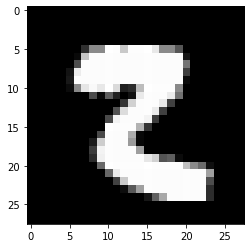

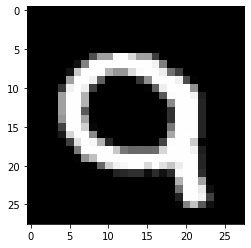

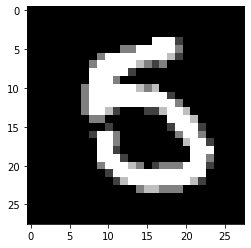

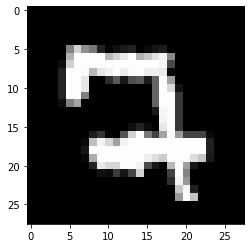

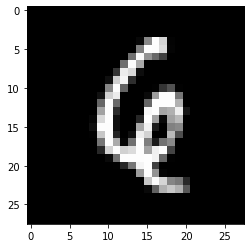

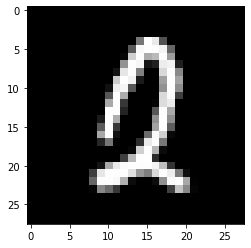

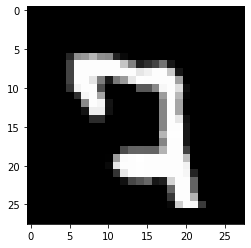

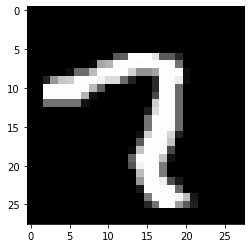

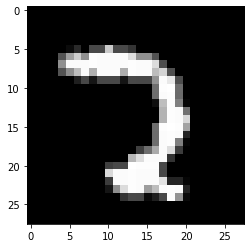

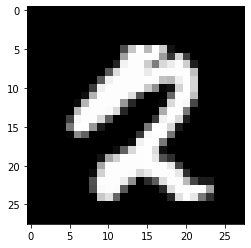

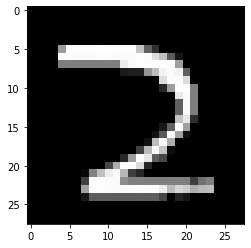

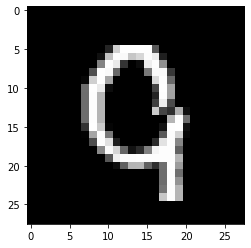

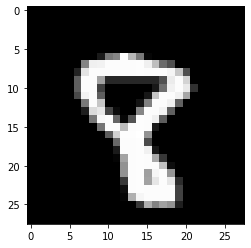

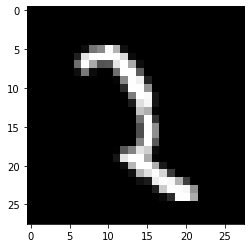

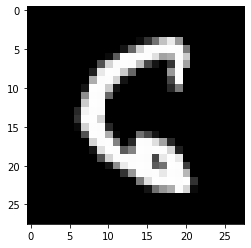

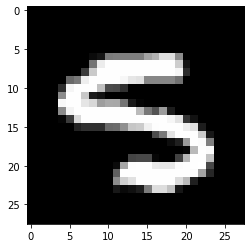

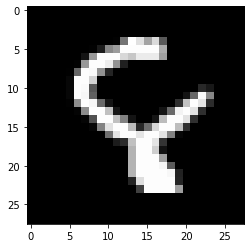

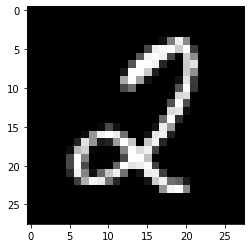

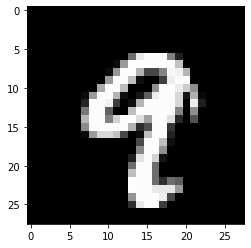

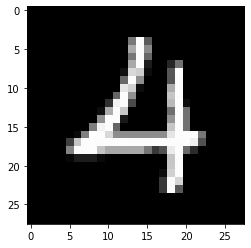

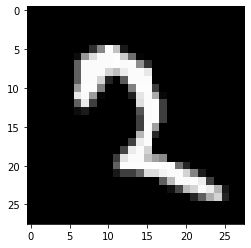

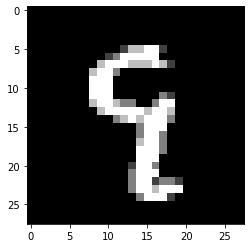

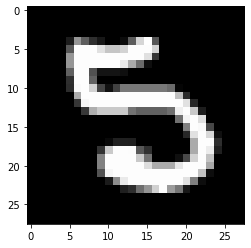

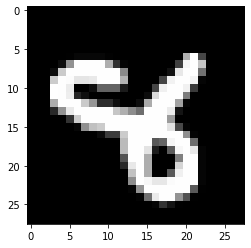

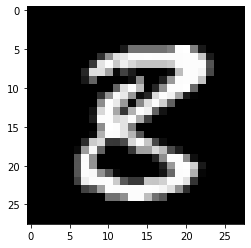

In [35]:
from matplotlib import pyplot as plt
for i in idx[:k]:
  image = X_val[i]
  pixels = image.reshape((28, 28))
  plt.imshow(pixels, cmap='gray')
  plt.show()